<a href="https://colab.research.google.com/github/LeoDinga/DL/blob/main/pytorch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Pytorch Tutorial
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# WORKING WITH DATA


In [ ]:
# Download TRAINING data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download TEST data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## CREATING MODELS

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the accelerator such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## OPTIMIZING THE MODEL PARAMETERS

To train the model we need the loss function and an optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model performance to againts the test data set to ensure it is learning

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (epocs). During each epoch, the model learns parameters to make better predictions.
We print the model's accuracy and loss at each epoch; we'd like to see the accuracy increase and the loss decrease with every epoch

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304215  [   64/60000]
loss: 2.286921  [ 6464/60000]
loss: 2.270357  [12864/60000]
loss: 2.264478  [19264/60000]
loss: 2.255190  [25664/60000]
loss: 2.218868  [32064/60000]
loss: 2.229124  [38464/60000]
loss: 2.199551  [44864/60000]
loss: 2.188110  [51264/60000]
loss: 2.150312  [57664/60000]
Test Error: 
 Accuracy: 44.9%, Avg loss: 2.153815 

Epoch 2
-------------------------------
loss: 2.169574  [   64/60000]
loss: 2.155012  [ 6464/60000]
loss: 2.096478  [12864/60000]
loss: 2.107938  [19264/60000]
loss: 2.080554  [25664/60000]
loss: 2.010875  [32064/60000]
loss: 2.023860  [38464/60000]
loss: 1.954648  [44864/60000]
loss: 1.943838  [51264/60000]
loss: 1.867742  [57664/60000]
Test Error: 
 Accuracy: 62.4%, Avg loss: 1.879318 

Epoch 3
-------------------------------
loss: 1.913453  [   64/60000]
loss: 1.884010  [ 6464/60000]
loss: 1.762491  [12864/60000]
loss: 1.798203  [19264/60000]
loss: 1.724592  [25664/60000]
loss: 1.652154  [32064/600

## SAVING MODELS

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## LOADING MODELS

In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

This model can now be used to make predictions

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# TENSORS

Tensors are a specialized data structure that are very similar to arrays and matrices. In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model’s parameters.

Tensors are similar to NumPy’s ndarrays, except that tensors can run on GPUs or other hardware accelerators. In fact, tensors and NumPy arrays can often share the same underlying memory, eliminating the need to copy data.
ensors are also optimized for automatic differentiation.

In [ ]:
import numpy as np

## Initializinga a Tensor

Tensors can be initialized in various ways


**Directly from data**

In [ ]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

**From a NumPy array**

In [ ]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

**From another tensor**

In [ ]:
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.3493, 0.4903],
        [0.1048, 0.4242]]) 



**With random or constant values**

In [ ]:
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[6.1185e-01, 2.5785e-04, 1.0633e-01],
        [4.3547e-01, 4.8780e-01, 1.4198e-01]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


## Attributes of a Tensor

Tensor attributes describe their shape, datatype, and the device on which they are stored

In [ ]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


## Operations on Tensors
Over 1200 tensor operations, including arithmetic, linear algebra, matrix manipulation (transposing, indexing, slicing) sampling and more.


In [ ]:
# We move our tensor to the current accelerator if available
if torch.accelerator.is_available():
    tensor = tensor.to(torch.accelerator.current_accelerator())

**Standard numpy-like indexing and slicing**

In [ ]:
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:,1] = 0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


**Joining tensors**
 You can use `torch.cat` to concatenate a sequence of tensors along a given dimension. See also `torch.stack`, another tensor joining operator that is subtly different from the previous one.

In [ ]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

t11 = torch.stack([tensor, tensor, tensor], dim=1)
print(t11)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])
tensor([[[1., 0., 1., 1.],
         [1., 0., 1., 1.],
         [1., 0., 1., 1.]],

        [[1., 0., 1., 1.],
         [1., 0., 1., 1.],
         [1., 0., 1., 1.]],

        [[1., 0., 1., 1.],
         [1., 0., 1., 1.],
         [1., 0., 1., 1.]],

        [[1., 0., 1., 1.],
         [1., 0., 1., 1.],
         [1., 0., 1., 1.]]])


**Arithmetic operations**

In [ ]:
# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
# ``tensor.T`` returns the transpose of a tensor
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)


# This computes the element-wise product. z1, z2, z3 will have the same value
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)


tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

**Single-element tensors**

If you have a one-element tensor, for example by aggregating all values of a tensor into one value, you can convert it to a Python numerical value using `item()`

In [ ]:
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

12.0 <class 'float'>


**In-place operations**

Operations that store the result into the operand are called in-place. They are denoted by a `_` suffix. For example: `x.copy_(y)`,`x.t_()` , will change `x`.

In [ ]:
print(f"{tensor} \n")
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


### NOTE

***In-place operations save some memory, but can be problematic when computing derivatives because of an immediate loss of history. Hence, their use is discouraged.***

## Bridge with NumPy
Tensors on the CPU and NumPy arrays can share their underlying memory locations, and changing one will change the othe

**Tensor to Numpy array**

In [ ]:
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


A change in the tensor reflects in the NumPy array.

In [ ]:
t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


**NumPy array to Tensor**

In [ ]:
n = np.ones(5)
t = torch.from_numpy(n)

Changes in the NumPy array reflects in the tensor

In [ ]:
np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
n: [2. 2. 2. 2. 2.]


# Datasets & DataLoaders

Ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.


## Loading a Dataset

How to load Fashion-MNIST dataset from TorchVision

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## Iterating and Visualizing the Dataset

We can index `Datasets` manually like a list: `training_data[index]`. We use matplolib to visualize some samples in our training data.



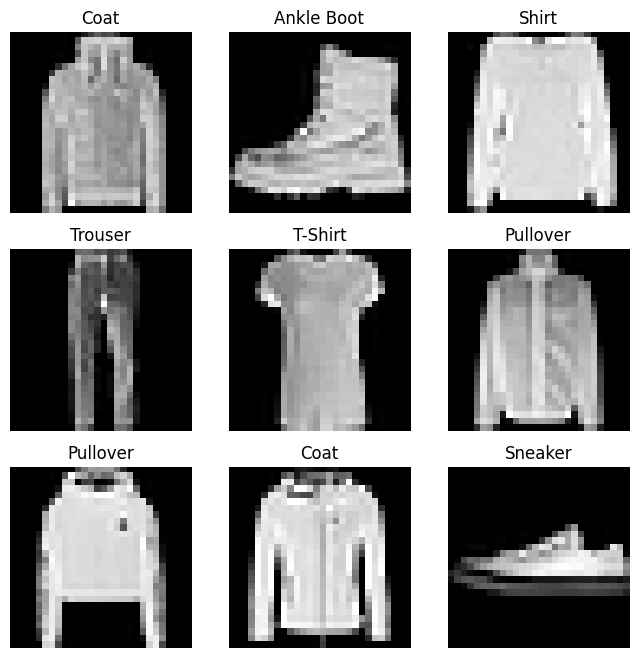

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Creating a Custom Dataset for your files

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`. Take a look at this implementation; the FashionMNIST images are stored in a directory `img_dir`, and their labels are stored separately in a CSV file `annotations_file`.

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

##`__init__`

The __int_function is run once when instatiating the Dataset object.
We initialize the directory containing the images, the annotations file, and both transforms (covered in more detail in the next section).

In [ ]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

##`__len__`

The `__len__` function returns the number of samples in our dataset



In [ ]:
def __len__(self):
    return len(self.img_labels)

##`__getitem__`

The`__getitem__` function loads and returns a sample from the dataset at the given index `idx`.
Basde on the index it identifies the image's location on disk converts that to a tensor using `read_image retrieves the corresponding label from the csv data in `self.image_labels, calls the transform function on them (if applicable), and returns the tensor image and corresponding label in a tuple


In [ ]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

# Tensors

Transforms are used to perform some manipulation of the data and make it suiable for training.

The parameters:

-`transform` modify the features
_`target_transform` modify the labels

The FashionMNIST features are in PIL Image format, and the labels are integers

In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

##ToTensor()

ToTensor converts PIL image or NumPy `ndarray` into a `FloatTensor`and scales the images´s pixels intensity values in the range[0., 1.]

##Lambda Transforms

apply any user-defined lamba functions
Below we define a function to turn the integer into a one-hot encoded tensor.
First it creates a zero tensor of size 10 (number of labels in the dataet ) and calls `scatter_` which assigns a `value=1` on the index as given by the label `y`

In [ ]:
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

#Build a Neural Network

Neural Networks compromise of layers/modelues that perform operations on data.
The `torch.nn` namespace provides all the building blocks you need to build your own neural network
Every module in PyTorch subclass the nn.Module.
A NN is a model itself that consists of other modules (layers). This nested structure allows for building and managinf complex architectures easily.


Build a NN to classify the images on the FashionMNIST dataset.

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

##Get Device dot Training

We waant to train the model on a accelarator (CUDA, MPS, MTIA, or XPU)



In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Define the class

We define our neural network by subclassing `nn.Module` and initialize the NN layers in `__init__`
Every `nn.Module` subclass implements the operations on the input data in the forward method.


In [3]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)

    )

  def forward(self, x):
      x = self.flatten(x)
      logits = self.linear_relu_stack(x)
      return logits

In [4]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model we pass it the input data
This executes the model's forward, along with some background operations.
**DO NOT CALL `model.forward()`DIRECTLY**

Calling the model on the input returns a 2-dimensional tensor with dim=0 correpsonding to each output raw predicted values for each class, and dim=1 corresponding to the individual values of each output. We get prediction probabilities by passing it through an instance of the `nn.Softmax`



In [5]:
X = torch.rand(1, 28, 28, device=device)

logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([3])


##Model layers

We''l take a minibatch of 3 images of size 28x28 and see what happens to it as we pass it through the network





In [6]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


##nn.Flatten

We initialize the `nn.Faltten` layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values (the minibatch dimension (at dim=0) is maintained)



In [7]:
flatten = nn.Flatten()

flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


##nn.Linear

The linear layer is a modulethat applies a linear transformation on the input using it stored weights and biases




In [8]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html